In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadCSVData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN
from commonModel import limitDataUsingProcentiles, limitDataUsingLimitsFromFilename

dataFileName   = "input/NizhnyNovgorod.csv"
limitsFileName = "input/NizhnyNovgorodLimits.json"

#dataFileName   = "input/SaintPetersburg.csv"
#limitsFileName = "input/SaintPetersburgLimits.json"

#dataFileName   = "input/Moscow.csv"
#limitsFileName = "input/MoscowLimits.json"

allDataFrame = loadCSVData( dataFileName, COLUMN_TYPE='NUMERICAL' )
allDataFrame = limitDataUsingLimitsFromFilename( allDataFrame, limitsFileName )
allDataFrame = limitDataUsingProcentiles       ( allDataFrame )

mask = (allDataFrame.price <= 10000000) & (allDataFrame.price > 1000000)
allDataFrame = allDataFrame[ mask ]
#latitude  = 55.751999;longitude = 37.617734;
#latitude_s  = allDataFrame['latitude' ].values
#longitude_s = allDataFrame['longitude'].values
#allDataFrame['distance_from_kremlin'] = np.sqrt( (latitude_s - latitude)**2 + (longitude_s - longitude)**2 )
#allDataFrame = inputDataFrame[FEATURES]
allDataFrame.head(10)

/home/sergey/My_trash/GEO_GID/commonModel.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataFrame.drop(labels=['kitchen_square','living_square','floor_number'], axis=1, inplace=True)


,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year
0,2850000.0,44.075417,56.283863,43.000000,1.0,17.0,2011.0
1,2600000.0,43.923782,56.310448,64.000000,4.0,5.0,1974.0
2,2750000.0,44.064953,56.291500,50.000000,2.0,5.0,1987.0
3,3700000.0,43.996544,56.317806,45.000000,2.0,8.0,1969.0
4,4760000.0,43.943588,56.294998,105.000000,4.0,9.0,1975.0
5,2960000.0,43.957848,56.333199,39.000000,1.0,9.0,2008.0
6,3400000.0,44.073002,56.283863,44.000000,1.0,17.0,2010.0
7,4000000.0,44.019955,56.321625,64.000000,3.0,9.0,1969.0
8,2500000.0,44.058098,56.299377,45.299999,2.0,9.0,1982.0
9,1600000.0,43.859066,56.251022,30.000000,1.0,9.0,1984.0


In [4]:
allDataFrame.describe()

,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year
count,16302.00,16302.000000,16302.000000,16302.000000,16302.000000,16302.000000,16302.000000
mean,3305959.00,43.935036,56.299576,54.716698,2.111397,9.330757,1982.812622
std,1481675.25,0.079691,0.039039,20.132610,0.920018,4.995959,22.653215
min,1030000.00,43.739635,56.163158,13.000000,1.000000,2.000000,1898.000000
25%,2250000.00,43.864496,56.266232,40.299999,1.000000,5.000000,1966.000000
50%,2950000.00,43.933025,56.301987,50.820000,2.000000,9.000000,1981.000000
75%,4000000.00,44.005985,56.328854,66.000000,3.000000,10.000000,2005.000000
max,10000000.00,44.099152,56.391964,191.139999,9.000000,28.000000,2017.000000


In [5]:
import torch
import _pickle as cPickle
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
Model         = None
Features      = None
preprocessorX = None
preprocessorY = None
with open( "modelNizhnyNovgorod.pkl", 'rb') as fid:
#with open( "modelSaintPetersburg.pkl", 'rb') as fid:
#with open( "modelMoscow.pkl", 'rb') as fid:
    ModelPacket = cPickle.load(fid)
    Model         = ModelPacket['model'        ]
    Features      = ModelPacket['features'     ]
    preprocessorX = ModelPacket['preprocessorX']
    preprocessorY = ModelPacket['preprocessorY']
index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       
Y_values    = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); 
X_dataFrame = X_dataFrame[ Features ]

X_values    = X_dataFrame.values
Y_values    = Y_values

X_numpy = preprocessorX.transform( X_values )
Y_numpy = preprocessorY.transform( Y_values )

X_torch = torch.from_numpy( X_numpy.astype( np.float32 ) ).to( device )
Y_torch = Model( X_torch )
Y_predict = Y_torch.detach().numpy()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_numpy, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_numpy, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_numpy, Y_predict ) )

Y_predict = preprocessorY.inverse_transform( Y_predict ).ravel()
Y_values  = Y_values.ravel()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

Errors on the test set
mean square:      0.0023325798
mean absolute:    0.029663188
median_absolute:  0.017956004
Errors on the test set
mean square:      279682150000.0
mean absolute:    324811.9
median_absolute:  196618.25


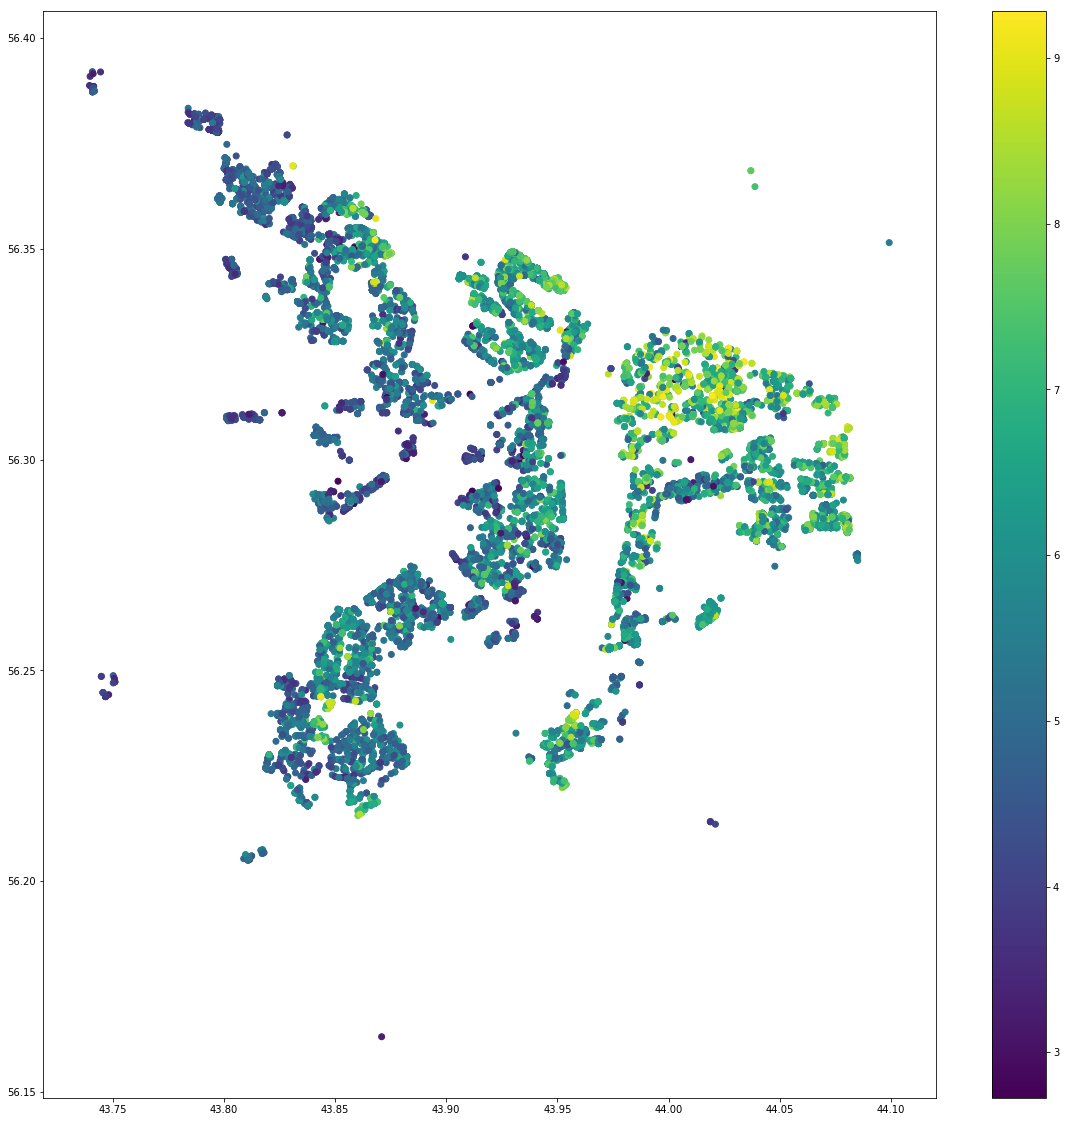

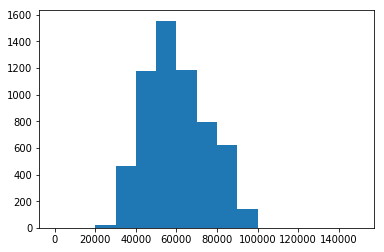

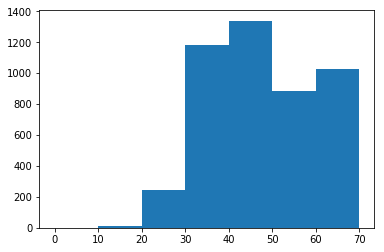

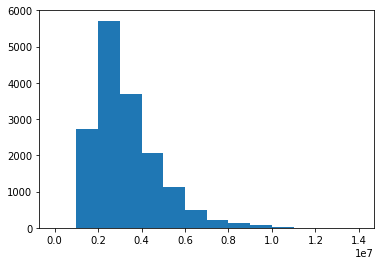

In [6]:
pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
TotalSquare          = allDataFrame['total_square']
Price                = allDataFrame['price']

pricePerSquareValues = pricePerSquare.values
TotalSquareValues    = TotalSquare.values
PriceValues          = Price.values

x = X_values[:,0]; y = X_values[:,1];

plt.figure(figsize=(20,20))
plt.scatter (x, y, c=pricePerSquareValues/10000  )
plt.colorbar()
plt.show()

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
mask = Y_relErr > 10
pricePerSquareValues = pricePerSquareValues[ mask ]
TotalSquareValues    = TotalSquareValues   [ mask ]
Price                = Price               [ mask ]

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.]
bins = [i * 1e4 for i in bins]
plt.hist( pricePerSquareValues, bins=bins )
plt.show()

bins = [0,10,20,30,40,50,60,70]
plt.hist( TotalSquareValues, bins=bins )
plt.show()

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.]
bins = [i * 1e6 for i in bins]
plt.hist( PriceValues      , bins=bins )
plt.show()


[3011778.2 3026368.2 2786341.2 ... 1999778.4 2553034.8 3339715.5]
[2850000. 2600000. 2750000. ... 2650000. 2790000. 3841000.]
threshold =   2.5, good =       3958, bad =      12344, err = 0.7572077045761256
threshold =   5.0, good =       6491, bad =       9811, err = 0.6018279965648387
threshold =  10.0, good =      10349, bad =       5953, err = 0.36516991780149677
threshold =  15.0, good =      12833, bad =       3469, err = 0.2127959759538707


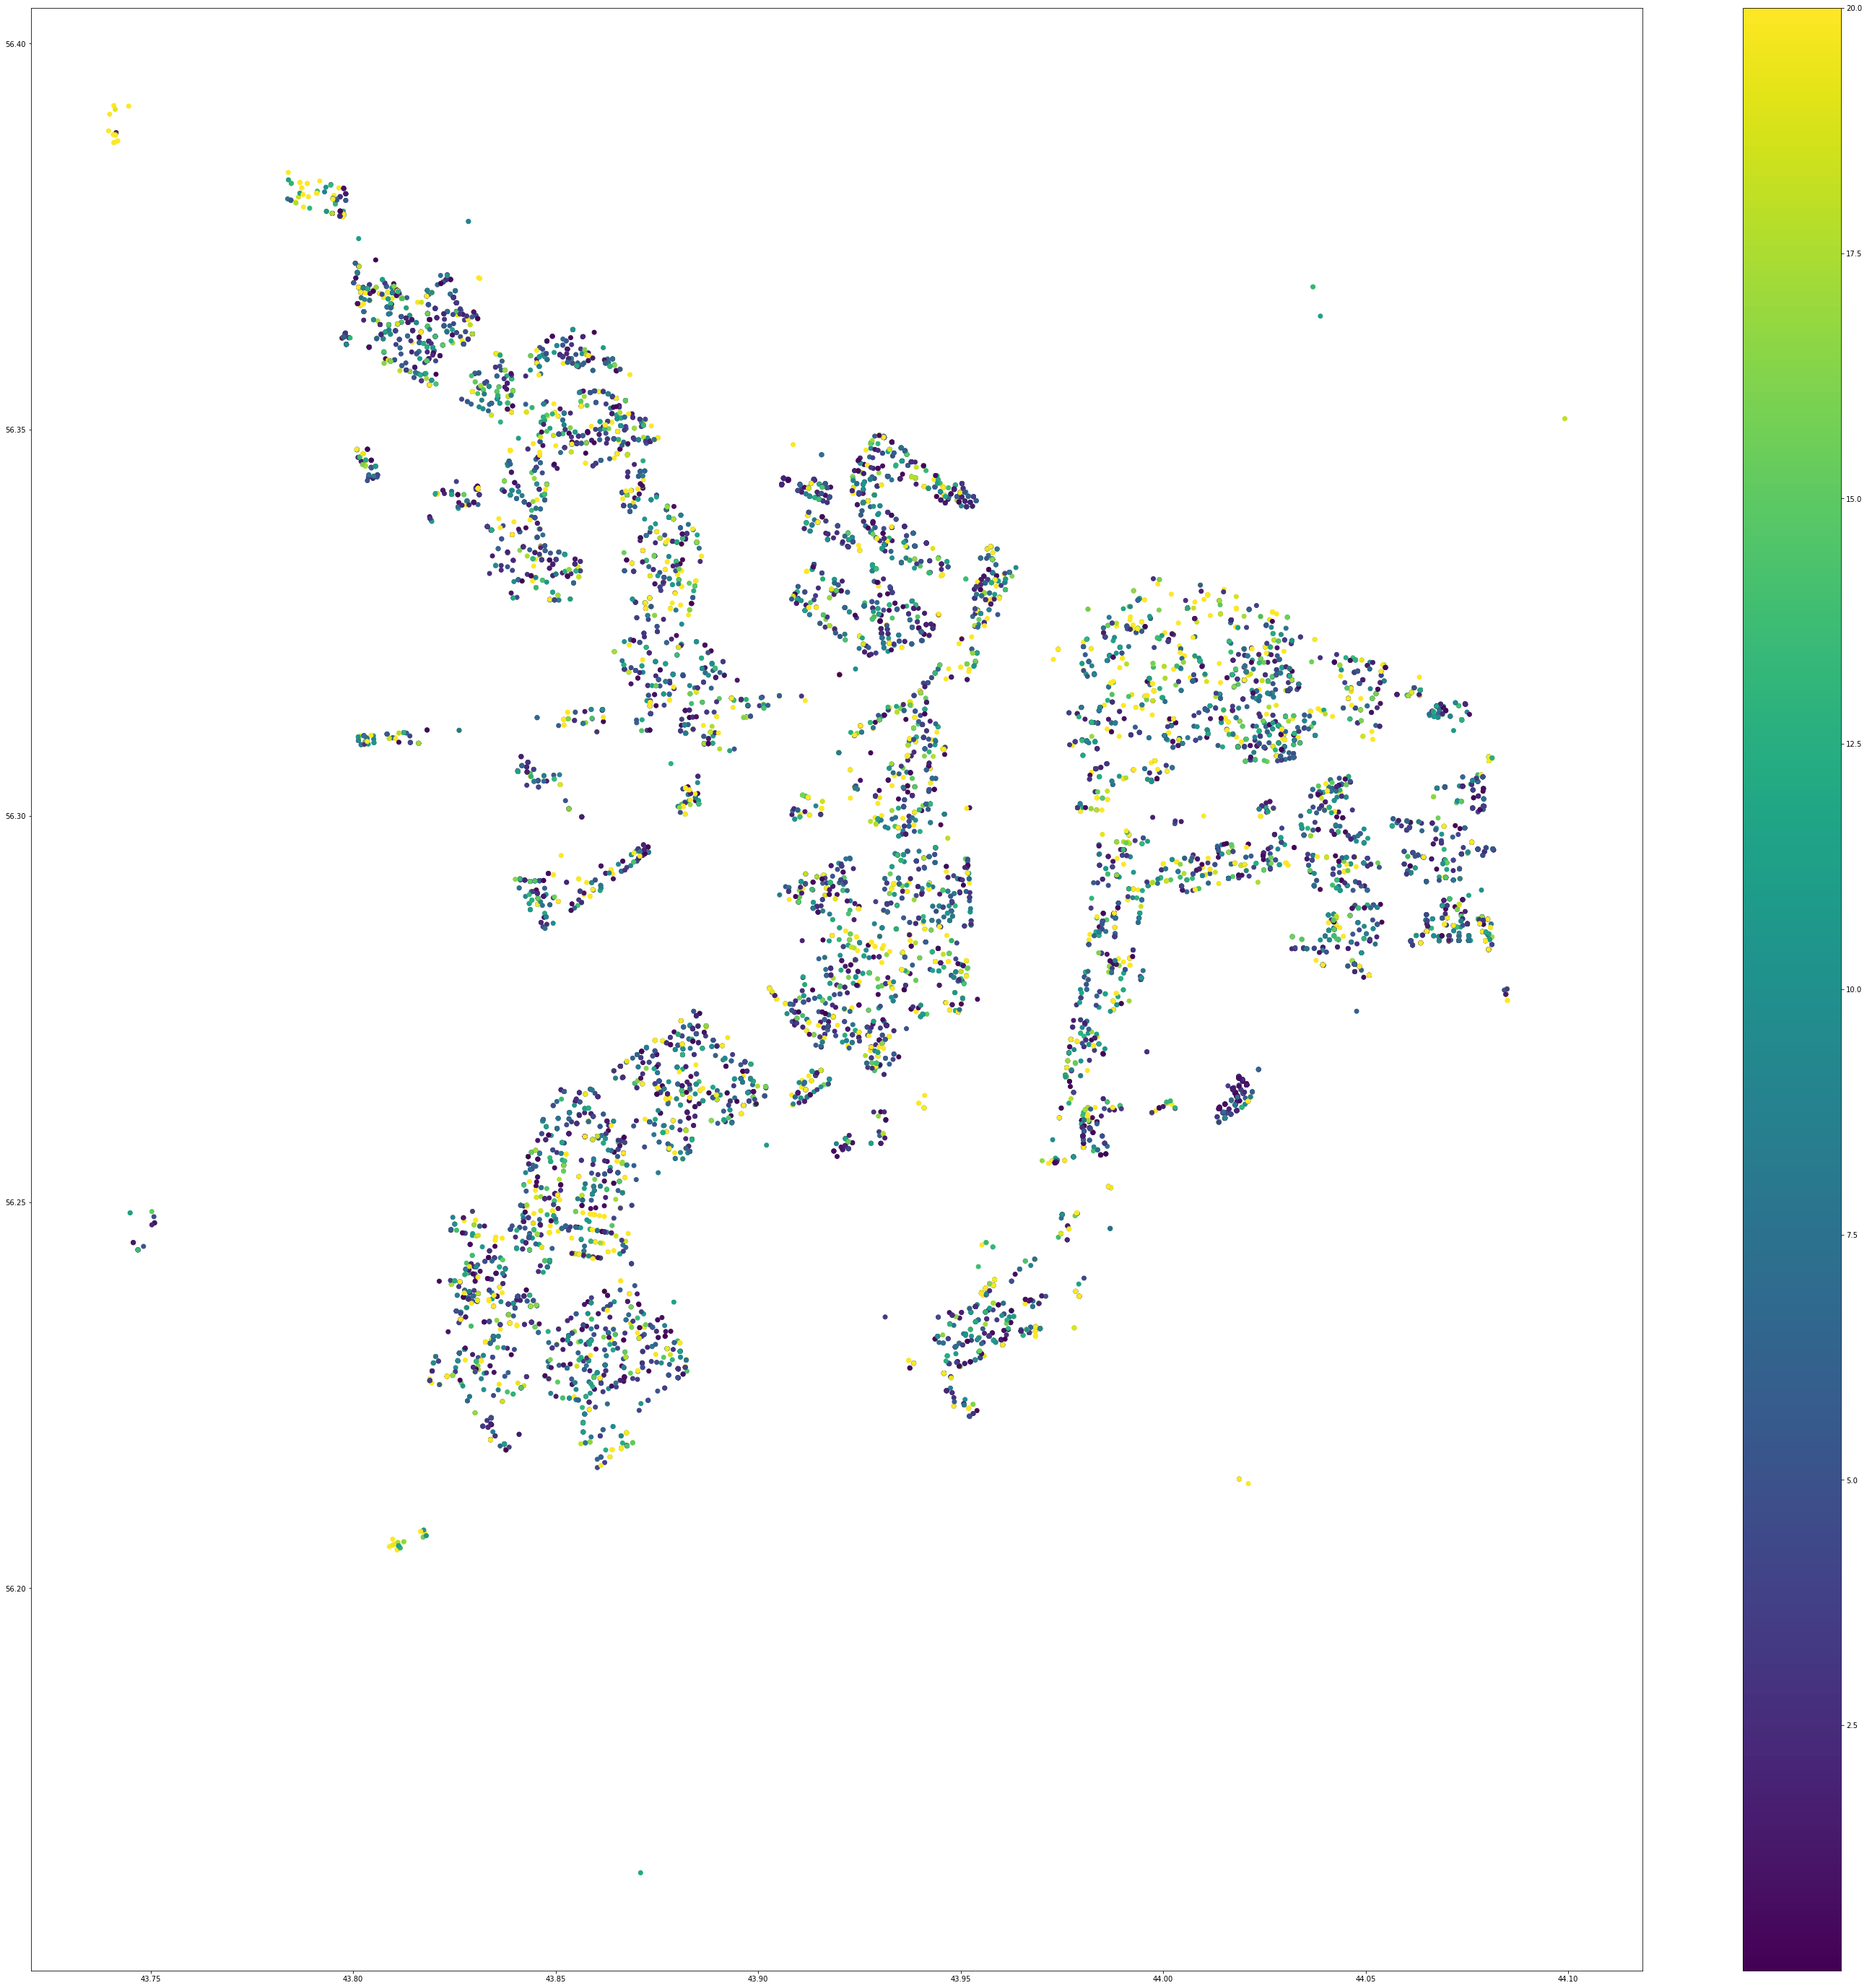

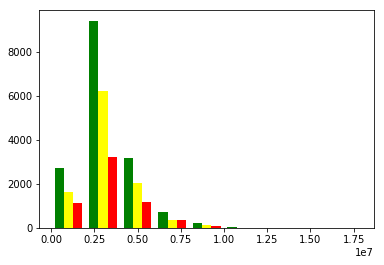

[2738 9421 3194  717  217   15    0    0    0]
[1618 6221 2018  370  115    7    0    0    0]
[1120 3200 1176  347  102    8    0    0    0]


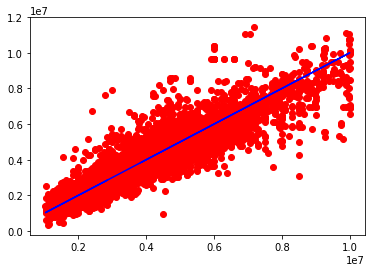

In [7]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

print( Y_predict )
print( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0, 15.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 20 );

plt.figure(figsize=(50,50))
plt.scatter (x, y, c=c  )
plt.colorbar()
plt.show()
"""
mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
plt.scatter (x_low, y_low, c=c_low, marker="*", s=75  )

mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'aqua'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=75  )
plt.show    ()
"""
threshold = 10
allTestDataValues  = testDataFrame.price.values
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.,2.,4.,6.,8.,10.,12.,14.,16.,18]
bins = [i * 1e6 for i in bins]

n = plt.hist([ allTestDataValues, goodTestDataValues, badTestDataValues ], bins=bins, histtype='bar', color=['green','yellow','red'])
plt.show()

print( n[0][0].astype(np.int64) )
print( n[0][1].astype(np.int64) )
print( n[0][2].astype(np.int64) )

plt.scatter(Y_values,Y_predict, color='red' )
plt.plot   (Y_values,Y_values , color='blue')
plt.show   ()

In [8]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

ImportError: cannot import name 'MAX_LONGITUDE'